In [11]:
import pandas as pd
import numpy as np


df_stocks_aapl = pd.read_csv("/content/drive/MyDrive/modelosIA/final_modelo_ia/data/stocks/AAPL.csv")

df_stocks_aapl["Date"] = pd.to_datetime(df_stocks.Date)
df_stocks_aapl.sort_values("Date", inplace=True)
print(df_stocks_aapl.describe())


                                Date         Open         High          Low  \
count                           9909  9909.000000  9909.000000  9909.000000   
mean   2000-07-30 08:33:08.010899200    32.606849    32.936079    32.277560   
min              1980-12-12 00:00:00     0.198661     0.198661     0.196429   
25%              1990-10-02 00:00:00     1.071429     1.089286     1.048571   
50%              2000-07-21 00:00:00     1.729286     1.758929     1.696429   
75%              2010-05-28 00:00:00    35.799999    36.265713    35.328571   
max              2020-04-01 00:00:00   324.739990   327.850006   323.350006   
std                              NaN    58.415759    59.001576    57.883037   

             Close    Adj Close        Volume  
count  9909.000000  9909.000000  9.909000e+03  
mean     32.618030    30.576570  8.582916e+07  
min       0.196429     0.155638  3.472000e+05  
25%       1.071429     0.917643  3.304230e+07  
50%       1.732143     1.466154  5.766490e+07  


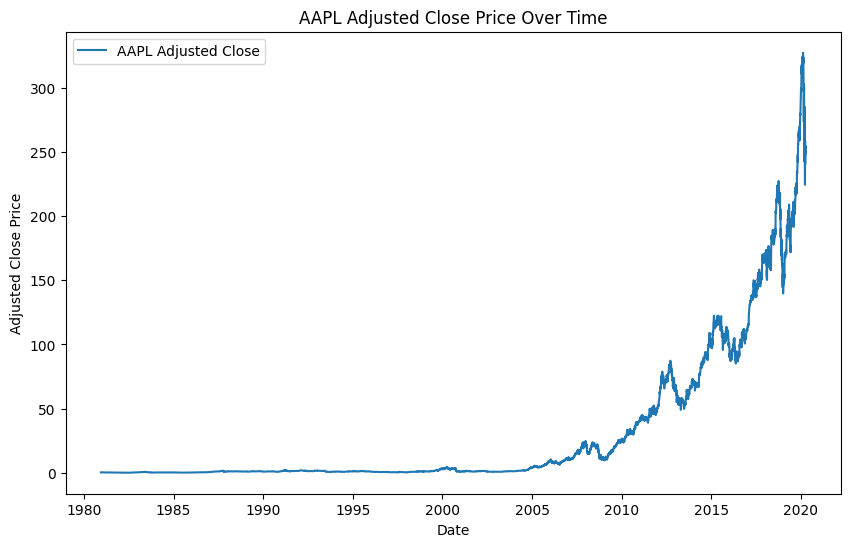

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(df_stocks_aapl['Date'], df_stocks_aapl['Adj Close'], label='AAPL Adjusted Close')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('AAPL Adjusted Close Price Over Time')
plt.legend()
plt.show()



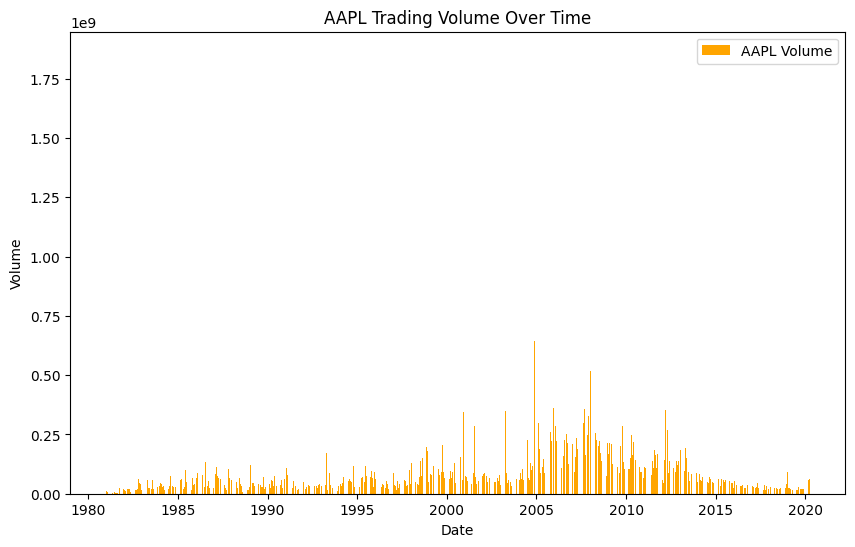

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(df_stocks_aapl['Date'], df_stocks_aapl['Volume'], color='orange', label='AAPL Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('AAPL Trading Volume Over Time')
plt.legend()
plt.show()



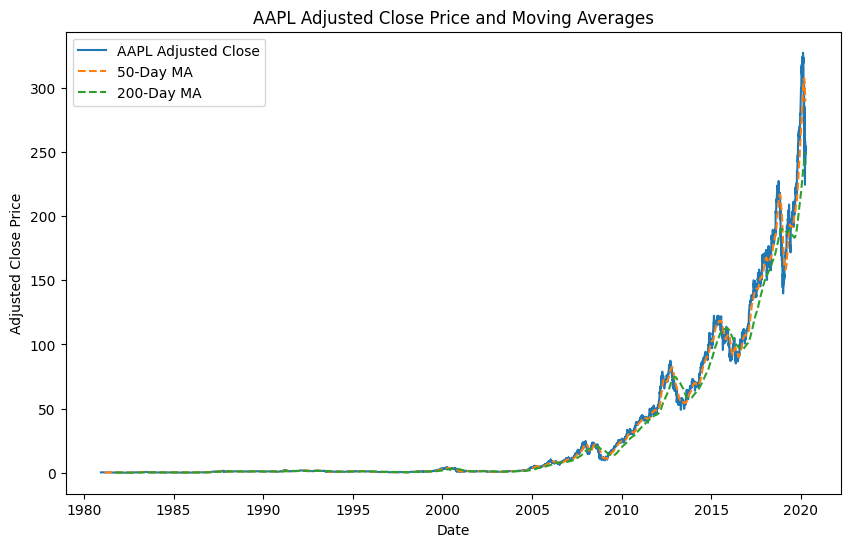

In [17]:
# Calculando médias móveis de 50 e 200 dias
df_stocks_aapl['50_MA'] = df_stocks_aapl['Adj Close'].rolling(window=50).mean()
df_stocks_aapl['200_MA'] = df_stocks_aapl['Adj Close'].rolling(window=200).mean()

# Plotando as médias móveis junto com o preço de fechamento ajustado
plt.figure(figsize=(10, 6))
plt.plot(df_stocks_aapl['Date'], df_stocks_aapl['Adj Close'], label='AAPL Adjusted Close')
plt.plot(df_stocks_aapl['Date'], df_stocks_aapl['50_MA'], label='50-Day MA', linestyle='--')
plt.plot(df_stocks_aapl['Date'], df_stocks_aapl['200_MA'], label='200-Day MA', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('AAPL Adjusted Close Price and Moving Averages')
plt.legend()
plt.show()


In [28]:
from sklearn.preprocessing import MinMaxScaler

data = df_stocks_aapl[['Adj Close']]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para criar uma estrutura de dados com look_back
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 4
X, Y = create_dataset(scaled_data, look_back)

# Reshape de X para [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [29]:
# Dividir os dados em treinamento e teste
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, Y_train, batch_size=1, epochs=1)


7923/7923 [==============================] - 50s 6ms/step - loss: 3.9205e-05


In [31]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverter a normalização
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calcular RMSE (Root Mean Squared Error)
train_score = np.sqrt(np.mean((train_predict - Y_train[0])**2))
test_score = np.sqrt(np.mean((test_predict - Y_test[0])**2))

print('Train RMSE: ', train_score)
print('Test RMSE: ', test_score)


62/62 [==============================] - 0s 4ms/step
Train RMSE:  16.423833526839168
Test RMSE:  84.42900998304687


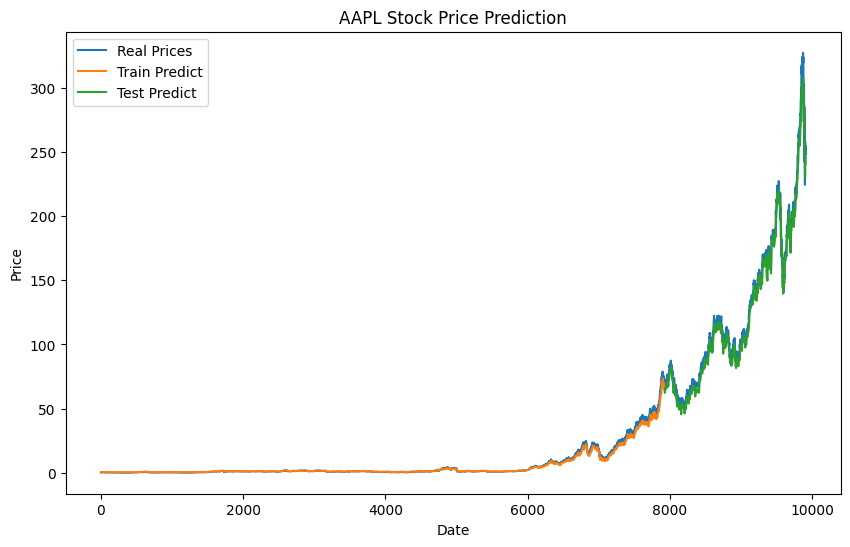

In [32]:
# Plotar os dados de treino e teste
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
# Adjusted the start index for the test predictions to ensure the correct number of elements are assigned
test_predict_plot[len(train_predict) + look_back : len(train_predict) + look_back + len(test_predict), :] = test_predict

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Real Prices')
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()